In [30]:
import sys

sys.path.append(
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages"
)

import biolib
import gzip
import os
import requests
import seaborn as sns
import tspex

import matplotlib.pyplot as plt
import pandas as pd

from io import StringIO

In [31]:
ALL_FASTA_OUTPUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\all_fasta_ht.fasta"
ALL_TARGETS_OUTPUT_DIRECTORY = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_all_targets_ht_panel"
ASSAY_LIST_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\ht_panel_assay_list.xlsx"
BRAIN_RNA_SEQ_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\brain_rna_seq.csv"
HGNC_IDS = "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt"
TMHMM_OUTPUT = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_all_targets_ht_panel\/TMRs.gff3"
UNIPROT_TO_FASTA_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\uniprotkb_proteome_UP000005640_2023_11_20.fasta.gz"

In [32]:
assay_list = pd.read_excel(ASSAY_LIST_PATH)


# Map UniProt IDs to the corresponding FASTA sequences


def parse_gz_file(file_path):
    protein_dict = {}
    current_uniprot_id = None
    current_sequence = ""
    with gzip.open(file_path, "rt") as f:
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if current_uniprot_id is not None:
                    protein_dict[current_uniprot_id] = current_sequence
                    current_sequence = ""
                if "|" in line:
                    current_uniprot_id = line.split("|")[1].strip()
                else:
                    print(f"Skipping line without expected format: {line}")
                    current_uniprot_id = None
            else:
                current_sequence += line
        if current_uniprot_id is not None:
            protein_dict[current_uniprot_id] = current_sequence
    return protein_dict

protein_data = parse_gz_file(UNIPROT_TO_FASTA_PATH)

assay_list["Sequence"] = assay_list["UniProt ID"].map(
    lambda x: protein_data.get(x, "N/A")
)

In [33]:
# # Create a FASTA file containing the information for the OLINK targets

# def export_fasta(output_path, df):
#     with open(output_path, "w") as output_file:
#         for index, row in df.iterrows():
#             output_file.write(f'>{row["UniProt ID"]}\n')
#             output_file.write(f'{row["Sequence"]}\n')
# export_fasta(ALL_FASTA_OUTPUT_PATH, assay_list)

# # Use the TMHMM deep learning model to predict the localication of each of the OLINK targets
# deeptmhmm = biolib.load("DTU/DeepTMHMM")
# def tmhmm_localization(targets, output_directory):
#     if not os.path.exists(output_directory):
#         os.makedirs(output_directory)
#     os.chdir(output_directory)
#     with open("query.fasta", "w") as fasta_file:
#         for _, row in targets.iterrows():
#             sequence = row["Sequence"]
#             uniprot_id = row["UniProt ID"]
#             fasta_line = f">{uniprot_id}\n{sequence}\n"
#             fasta_file.write(fasta_line)
#         biolib.utils.STREAM_STDOUT = True
#         deeptmhmm_job = deeptmhmm.cli(
#             args="--fasta query.fasta", machine="local"
#         )
#         deeptmhmm_job.save_files(output_directory)

# tmhmm_localization(assay_list, ALL_TARGETS_OUTPUT_DIRECTORY)

In [34]:
# Import the TMHMM output
with open(TMHMM_OUTPUT, "r") as gff_file:
    gff_lines = gff_file.readlines()

# Create lists to store data
uniprot_ids = []
region_locations = []
region_starts = []
region_ends = []

# Process each line in the GFF file
for line in gff_lines:
    # Skip lines starting with "//"
    if not line.startswith("//"):
        # Split the line by tabs
        columns = line.strip().split("\t")

        # Ensure that the line has enough columns
        if len(columns) >= 4:
            # Extract information from the columns
            uniprot_id = columns[0]
            region_location = columns[1]
            region_start = int(columns[2])
            region_end = int(columns[3])

            uniprot_ids.append(uniprot_id)
            region_locations.append(region_location)
            region_starts.append(region_start)
            region_ends.append(region_end)

# Create a new dataframe
data = {
    "UniProt ID": uniprot_ids,
    "Region Location": region_locations,
    "Region Start": region_starts,
    "Region End": region_ends,
}

tmhmm_df = pd.DataFrame(data)

tm_tmhmm = tmhmm_df[tmhmm_df["Region Location"] == "TMhelix"]
outside_tmhmm = tmhmm_df[tmhmm_df["Region Location"] == "outside"]
inside_tmhmm = tmhmm_df[tmhmm_df["Region Location"] == "inside"]

tm_uniprots = set(tm_tmhmm["UniProt ID"])
inside_uniprots = set(inside_tmhmm["UniProt ID"])
outside_uniprots = set(outside_tmhmm["UniProt ID"])

inside_uniprots = inside_uniprots - tm_uniprots - outside_uniprots
outside_uniprots = outside_uniprots - tm_uniprots - inside_uniprots

In [35]:
brain_rna_seq = pd.read_csv(BRAIN_RNA_SEQ_PATH)

# Find the mean expression of each cell type 
astrocyte_cols = [
    "astrocytes_mature_1",
    "astrocytes_mature_2",
    "astrocytes_mature_3",
    "astrocytes_mature_4",
    "astrocytes_mature_5",
    "astrocytes_mature_6",
    "astrocytes_mature_7",
    "astrocytes_mature_8",
    "astrocytes_mature_9",
    "astrocytes_mature_10",
    "astrocytes_mature_11",
    "astrocytes_mature_12",
]
brain_rna_seq['astrocytes'] = brain_rna_seq[astrocyte_cols].mean(axis=1)

endothelial_cols = ["endothelial_1", "endothelial_2"]
brain_rna_seq['endothelial'] = brain_rna_seq[endothelial_cols].mean(axis=1)

microglia_cols = ["microglla_1", "microglla_2", "microglla_3"]
brain_rna_seq['microglia'] = brain_rna_seq[microglia_cols].mean(axis=1)

oligodendrocyte_cols = [
    "oligodendrocytes_1",
    "oligodendrocytes_2",
    "oligodendrocytes_3",
    "oligodendrocytes_4",
    "oligodendrocytes_5",
]
brain_rna_seq['oligodendrocytes'] = brain_rna_seq[oligodendrocyte_cols].mean(axis=1)

brain_rna_seq["neurons"] = brain_rna_seq["neurons_1"]

brain_rna_seq = brain_rna_seq[["id", "astrocytes", "endothelial", "microglia", "neurons", "oligodendrocytes"]]

brain_rna_seq.set_index("id", inplace=True)

brain_rna_seq_no_duplicates = brain_rna_seq[~brain_rna_seq.index.duplicated()]

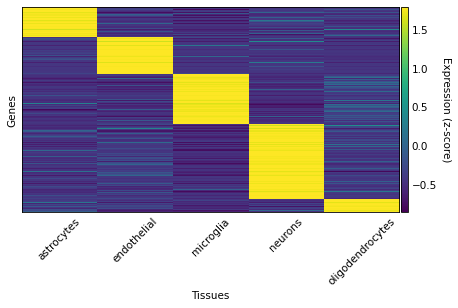

In [36]:
expression_data = brain_rna_seq_no_duplicates.loc[(brain_rna_seq_no_duplicates > 0).any(axis = 1)]

tso = tspex.TissueSpecificity(expression_data, 'tau', log=True)

tso.plot_heatmap(threshold=0.8, sort_genes=True, use_zscore=True, gene_names=False)

plt.show()

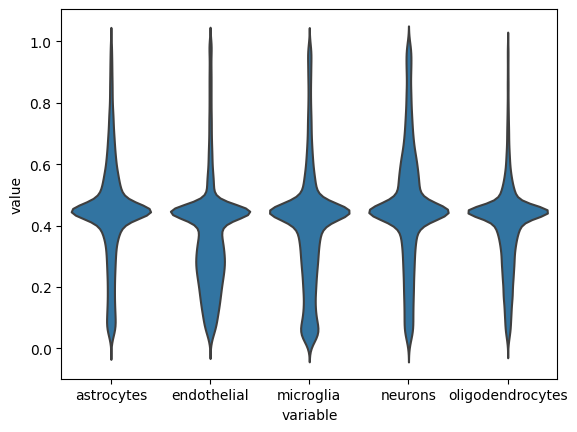

In [37]:
tso = tspex.TissueSpecificity(expression_data, 'spm', log=True)

sns.violinplot(x="variable", y="value", inner=None, scale="count", color='C0',
               data=tso.tissue_specificity.melt());
plt.show()

In [38]:
microglia_targets = tso.tissue_specificity.query('microglia >= 0.85')
oligodendrocyte_targets = tso.tissue_specificity.query('oligodendrocytes >= 0.85')
neuron_targets = tso.tissue_specificity.query('neurons >= 0.85')
astrocyte_targets = tso.tissue_specificity.query('astrocytes >= 0.85')

microglia_targets_hgnc = microglia_targets.index.tolist()
oligodendrocyte_targets_hgnc = oligodendrocyte_targets.index.tolist()
neuron_targets_hgnc = neuron_targets.index.tolist()
astrocyte_targets_hgnc = astrocyte_targets.index.tolist()

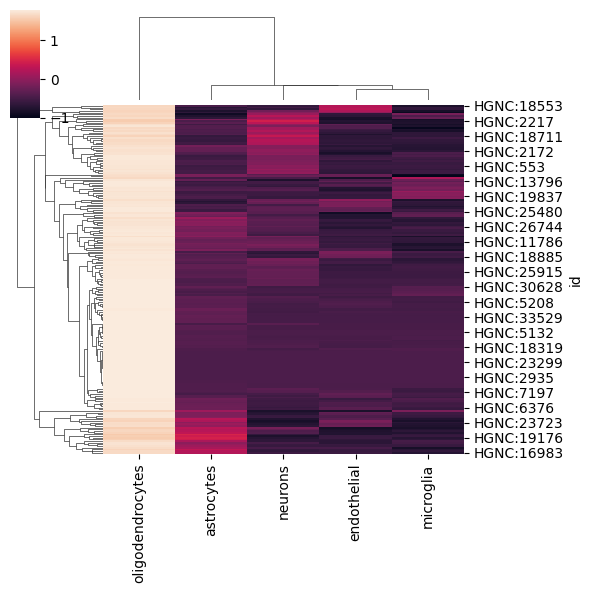

In [39]:
sns.clustermap(oligodendrocyte_targets, figsize=(6,6), z_score=0);

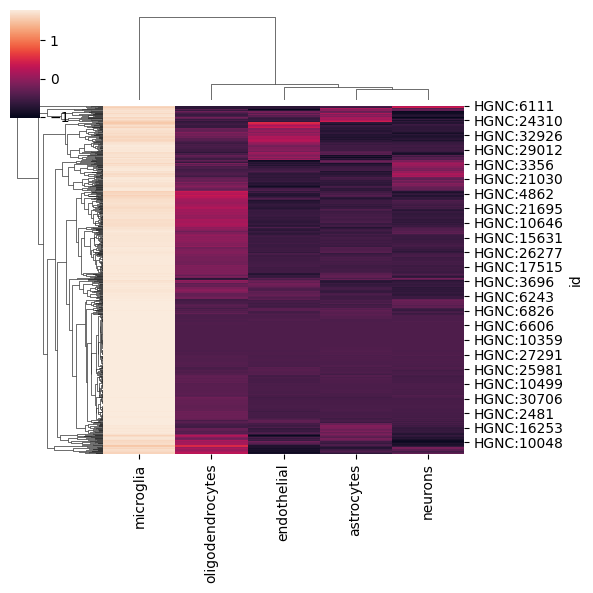

In [40]:
sns.clustermap(microglia_targets, figsize=(6,6), z_score=0);

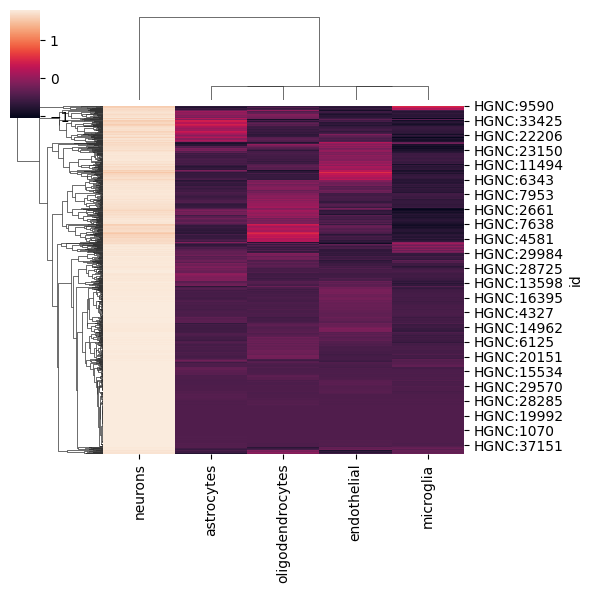

In [41]:
sns.clustermap(neuron_targets, figsize=(6,6), z_score=0);

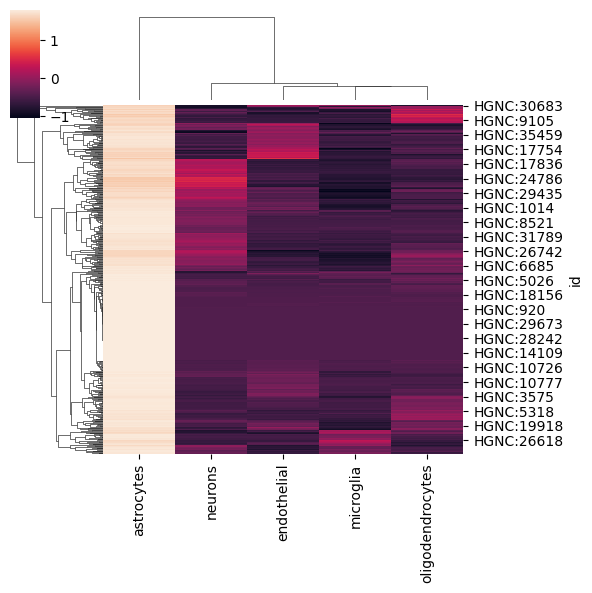

In [42]:
sns.clustermap(astrocyte_targets, figsize=(6,6), z_score=0);

In [64]:
# Map the HGNC IDs to the UniProt IDs

# This database that maps HGNC IDs to UniProt IDs doesn't have all the UniProt IDs we need, resulting in some targets being dropped unnecessarily
response = requests.get(HGNC_IDS)
content = response.text
file_like_object = StringIO(content)
uniprot_ids = pd.read_csv(file_like_object, sep="\t", low_memory=False)

# Create a list of UniProt IDs for each cell type

astrocyte_uniprots = uniprot_ids[
    uniprot_ids["hgnc_id"].isin(astrocyte_targets_hgnc)
]
oligodendrocyte_uniprots = uniprot_ids[
    uniprot_ids["hgnc_id"].isin(oligodendrocyte_targets_hgnc)
]

microglia_uniprots = uniprot_ids[
    uniprot_ids["hgnc_id"].isin(microglia_targets_hgnc)
]

neuron_uniprots = uniprot_ids[
    uniprot_ids["hgnc_id"].isin(neuron_targets_hgnc)
]

astrocyte_uniprots = list(astrocyte_uniprots["uniprot_ids"])
oligodendrocyte_uniprots = list(oligodendrocyte_uniprots["uniprot_ids"])
microglia_uniprots = list(microglia_uniprots["uniprot_ids"])
neuron_uniprots = list(neuron_uniprots["uniprot_ids"])

In [82]:
counts = assay_list["UniProt ID"].isin(neuron_uniprots)
counts.value_counts()

UniProt ID
False    5163
True      253
Name: count, dtype: int64

In [70]:
# filter the dataframe to only include targets that are 3x enriched in cell type of interest
brain_rna_seq = pd.read_csv(BRAIN_RNA_SEQ_PATH)


fetal_astrocytes_cols = [
    "gene_id",
    "id",
    "astrocytes_fetal_1",
    "astrocytes_fetal_2",
    "astrocytes_fetal_3",
    "astrocytes_fetal_4",
    "astrocytes_fetal_5",
    "astrocytes_fetal_6",
]  # should this list be in the first cell at the top of the file? (same question applies for the mature astrocyte, endothelial, microglia, oligodendrocytes lists)
fetal_astrocytes = brain_rna_seq[fetal_astrocytes_cols]

mature_astrocytes_cols = [
    "gene_id",
    "id",
    "astrocytes_mature_1",
    "astrocytes_mature_2",
    "astrocytes_mature_3",
    "astrocytes_mature_4",
    "astrocytes_mature_5",
    "astrocytes_mature_6",
    "astrocytes_mature_7",
    "astrocytes_mature_8",
    "astrocytes_mature_9",
    "astrocytes_mature_10",
    "astrocytes_mature_11",
    "astrocytes_mature_12",
]
mature_astrocytes = brain_rna_seq[mature_astrocytes_cols]

endothelial_cols = ["gene_id", "id", "endothelial_1", "endothelial_2"]
endothelial = brain_rna_seq[endothelial_cols]

microglia_cols = ["gene_id", "id", "microglla_1", "microglla_2", "microglla_3"]
microglia = brain_rna_seq[microglia_cols]

oligodendrocyte_cols = [
    "gene_id",
    "id",
    "oligodendrocytes_1",
    "oligodendrocytes_2",
    "oligodendrocytes_3",
    "oligodendrocytes_4",
    "oligodendrocytes_5",
]
oligodendrocytes = brain_rna_seq[oligodendrocyte_cols]

neurons_cols = ["gene_id", "id", "neurons_1"]
neurons = brain_rna_seq[neurons_cols]

not_mean_calc = ["gene_id", "id"]


def find_mean(row):
    row_series = pd.Series(row)
    return row_series.mean()


neurons["Mean"] = neurons.mean(axis=1, numeric_only=True)

oligodendrocytes["Mean"] = oligodendrocytes.mean(axis=1, numeric_only=True)

microglia["Mean"] = microglia.mean(axis=1, numeric_only=True)

endothelial["Mean"] = endothelial.mean(axis=1, numeric_only=True)

mature_astrocytes["Mean"] = mature_astrocytes.mean(axis=1, numeric_only=True)

fetal_astrocytes["Mean"] = fetal_astrocytes.mean(axis=1, numeric_only=True)

# filter the dataframes to only include proteins where microglia expression is 3x greater than other cell type expression
microglia_targets = microglia[
    (microglia["Mean"] > (3 * oligodendrocytes["Mean"]))
    & (microglia["Mean"] > (3 * endothelial["Mean"]))
    & (microglia["Mean"] > (3 * mature_astrocytes["Mean"]))
    # & (microglia["Mean"] > (3 * fetal_astrocytes["Mean"]))
    & (microglia["Mean"] > (3 * neurons["Mean"]))
]

microglia_targets = list(microglia_targets["id"])

# filter the dataframes to only include proteins where oligodendrocyte expression is 3x greater than other cell type expression
oligodendrocyte_targets = oligodendrocytes[
    (oligodendrocytes["Mean"] > (3 * microglia["Mean"]))
    & (oligodendrocytes["Mean"] > (3 * endothelial["Mean"]))
    & (oligodendrocytes["Mean"] > (3 * mature_astrocytes["Mean"]))
    # & (oligodendrocytes["Mean"] > (3 * fetal_astrocytes["Mean"]))
    & (oligodendrocytes["Mean"] > (3 * neurons["Mean"]))
]

oligodendrocyte_targets = list(oligodendrocyte_targets["id"])

# filter the dataframes to only include proteins where mature astrocyte expression is 3x greater than other cell type expression
mature_astrocyte_targets = mature_astrocytes[
    (mature_astrocytes["Mean"] > (3 * microglia["Mean"]))
    & (mature_astrocytes["Mean"] > (3 * endothelial["Mean"]))
    & (mature_astrocytes["Mean"] > (3 * oligodendrocytes["Mean"]))
    # & (mature_astrocytes["Mean"] > (3 * fetal_astrocytes["Mean"]))
    & (mature_astrocytes["Mean"] > (3 * neurons["Mean"]))
]

mature_astrocyte_targets = list(mature_astrocyte_targets["id"])


# filter the dataframes to only include proteins where neurons expression is 3x greater than other cell type expression
neuron_targets = neurons[
    (neurons["Mean"] > (3 * microglia["Mean"]))
    & (neurons["Mean"] > (3 * endothelial["Mean"]))
    & (neurons["Mean"] > (3 * oligodendrocytes["Mean"]))
    # & (neurons["Mean"] > (3 * fetal_astrocytes["Mean"]))
    & (neurons["Mean"] > (3 * mature_astrocytes["Mean"]))
]

neuron_targets = list(neuron_targets["id"])

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_11608\2993694030.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neurons["Mean"] = neurons.mean(axis=1, numeric_only=True)
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_11608\2993694030.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oligodendrocytes["Mean"] = oligodendrocytes.mean(axis=1, numeric_only=True)
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_11608\2993694030.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [71]:
# Map the HGNC IDs to the UniProt IDs

# This database that maps HGNC IDs to UniProt IDs doesn't have all the UniProt IDs we need, resulting in some targets being dropped unnecessarily
response = requests.get(HGNC_IDS)
content = response.text
file_like_object = StringIO(content)
uniprot_ids = pd.read_csv(file_like_object, sep="\t", low_memory=False)

# Create a list of UniProt IDs for each cell type

mature_astrocyte_hgnc_df = uniprot_ids[
    uniprot_ids["hgnc_id"].isin(mature_astrocyte_targets)
]
mature_astrocyte_uniprot_ids = mature_astrocyte_hgnc_df["uniprot_ids"].tolist()

oligodendrocyte_hgnc_df = uniprot_ids[
    uniprot_ids["hgnc_id"].isin(oligodendrocyte_targets)
]
oligodendrocyte_uniprot_ids = oligodendrocyte_hgnc_df["uniprot_ids"].tolist()

microglia_hgnc_df = uniprot_ids[uniprot_ids["hgnc_id"].isin(microglia_targets)]
microglia_uniprot_ids = microglia_hgnc_df["uniprot_ids"].tolist()

neuron_hgnc_df = uniprot_ids[uniprot_ids["hgnc_id"].isin(neuron_targets)]
neuron_uniprot_ids = neuron_hgnc_df["uniprot_ids"].tolist()

In [85]:
counts = assay_list["UniProt ID"].isin(mature_astrocyte_uniprot_ids)
counts.value_counts()

UniProt ID
False    5220
True      196
Name: count, dtype: int64